# Safe Route AI – Model Metrics & Visualizations

This notebook regenerates key metrics and visualizations for the core models:

- Predictive Safety Model (Random Forest)
- Crime Hotspot Clustering (K-Means)
- Route Safety Optimizer (heuristic composite score)

Each section trains/loads the relevant component and renders visuals suitable for presentations.


In [8]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure project modules are on the path
PROJECT_ROOT = Path.cwd()
if (PROJECT_ROOT / "pythonScript").exists():
    sys.path.append(str(PROJECT_ROOT / "pythonScript"))
else:
    # Notebook may be opened from a subdirectory
    parent_with_scripts = PROJECT_ROOT.parent
    sys.path.append(str(parent_with_scripts / "pythonScript"))

sns.set_theme(style="whitegrid")
print(f"Working directory: {Path.cwd()}")


Working directory: c:\Users\Ayush chaudhary\Downloads\Nirbhaya-main\Nirabhaya-main\safe-route


In [9]:
from predictive_safety_model import PredictiveSafetyModel

safety_model = PredictiveSafetyModel()
training_data = safety_model.generate_synthetic_training_data()
model = safety_model.train_model(training_data)

X = training_data[safety_model.feature_columns]
y = training_data['safety_score']
X_scaled = safety_model.scaler.transform(X)
feature_importances = pd.Series(
    model.feature_importances_, index=safety_model.feature_columns
).sort_values(ascending=False)

print("Predictive Safety Model ready. Feature importances computed.")


Training Score: 1.000
Test Score: 1.000
Model saved to models/safety_model.pkl
Predictive Safety Model ready. Feature importances computed.


In [10]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_scaled = safety_model.scaler.transform(X_train)
X_test_scaled = safety_model.scaler.transform(X_test)

train_r2 = model.score(X_train_scaled, y_train)
test_r2 = model.score(X_test_scaled, y_test)

metrics_df = pd.DataFrame(
    {
        "Dataset": ["Train", "Test"],
        "R2 Score": [train_r2, test_r2]
    }
)
metrics_df


,Dataset,R2 Score
0,Train,0.999993
1,Test,0.999960


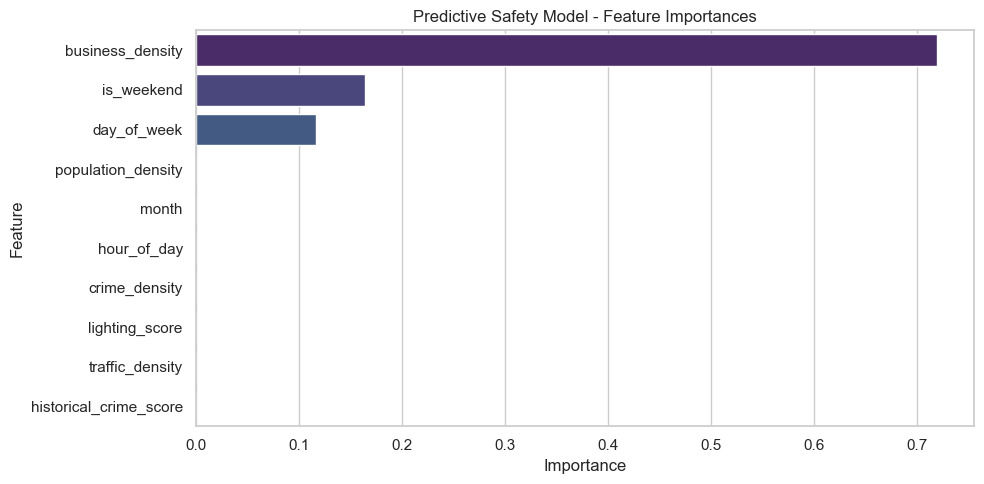

In [11]:
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Predictive Safety Model - Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

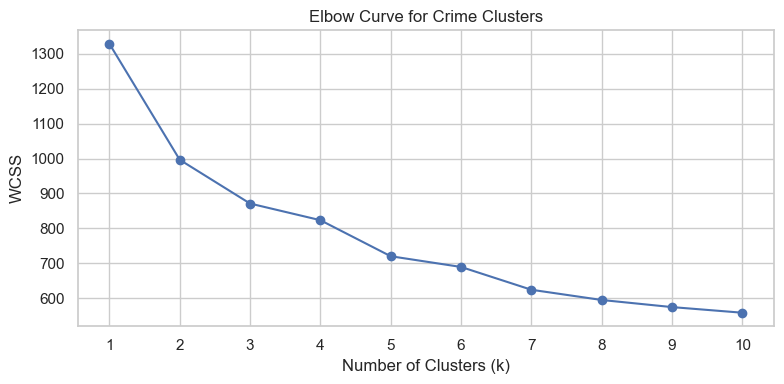

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


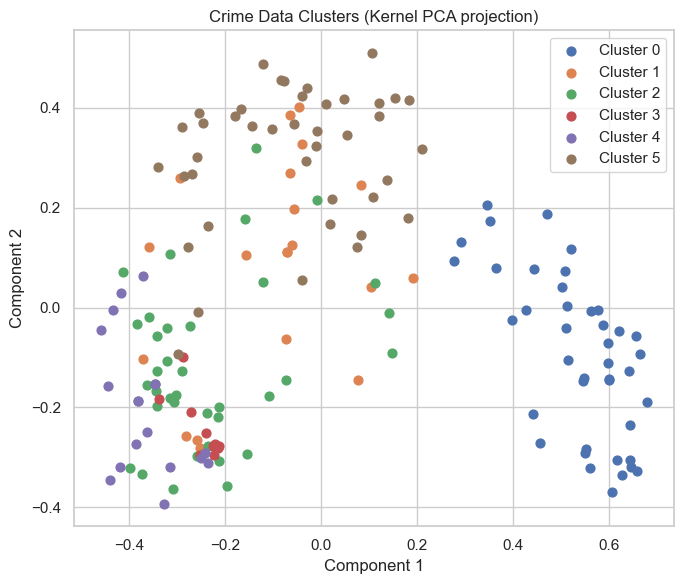

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA

data_path = PROJECT_ROOT / "data" / "crime.csv"
crime_df = pd.read_csv(data_path)
X_crime = crime_df.iloc[:, [1,2,3,4,5,6,7,12]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_crime)

wcss = []
cluster_range = range(1, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(cluster_range, wcss, marker='o')
plt.title('Elbow Curve for Crime Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(cluster_range)
plt.tight_layout()
plt.show()

kmeans_final = KMeans(n_clusters=6, init='k-means++', random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(X_scaled)
kpca = KernelPCA(n_components=2, kernel='rbf')
X_2d = kpca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
for label in np.unique(cluster_labels):
    plt.scatter(
        X_2d[cluster_labels == label, 0],
        X_2d[cluster_labels == label, 1],
        s=40,
        label=f"Cluster {label}"
    )
plt.title('Crime Data Clusters (Kernel PCA projection)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
from enhanced_route_optimizer import EnhancedRouteOptimizer

optimizer = EnhancedRouteOptimizer(safety_model=safety_model)
route = optimizer.optimize_route_with_safety_scoring(
    start_lat=28.6139,
    start_lng=77.2090,
    end_lat=28.6169,
    end_lng=77.2120
)

route_summary = pd.DataFrame(
    {
        "Metric": ["Total Safety Score", "Total Travel Time (min)", "Route Confidence"],
        "Value": [route.total_safety_score, route.total_travel_time, route.route_confidence]
    }
)
route_summary


,Metric,Value
0,Total Safety Score,396.913028
1,Total Travel Time (min),30.000000
2,Route Confidence,0.796192


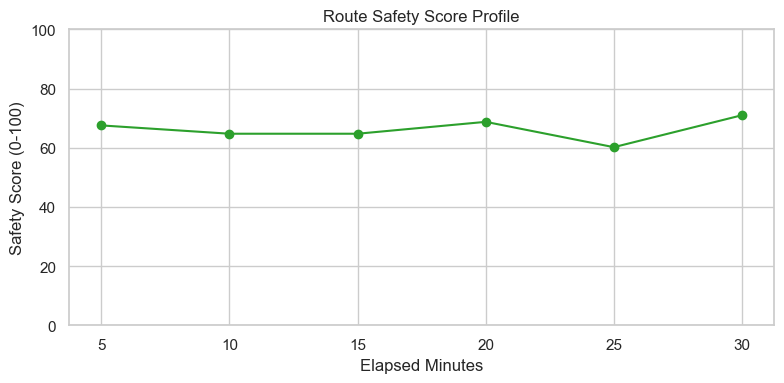

,elapsed_minutes,safety_score
0,5.0,67.539319
1,10.0,64.729713
2,15.0,64.729788
3,20.0,68.745978
4,25.0,60.182414
5,30.0,70.985816


In [14]:
route_points_df = pd.DataFrame(
    [
        {
            "lat": p.lat,
            "lng": p.lng,
            "safety_score": p.safety_score,
            "timestamp": p.timestamp,
            "cumulative_time": p.estimated_travel_time
        }
        for p in route.points
    ]
)
route_points_df['elapsed_minutes'] = route_points_df['cumulative_time'].cumsum()

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(route_points_df['elapsed_minutes'], route_points_df['safety_score'], marker='o', color='tab:green')
ax1.set_title('Route Safety Score Profile')
ax1.set_xlabel('Elapsed Minutes')
ax1.set_ylabel('Safety Score (0-100)')
ax1.set_ylim(0, 100)
plt.tight_layout()
plt.show()

route_points_df[['elapsed_minutes', 'safety_score']]


## Notes for Presentations

- R² values are based on freshly generated synthetic data; real-world performance will vary.
- K-Means visuals rely on `data/crime.csv`. Update the CSV to reflect the geography you plan to showcase.
- Route safety plots use the mock directions fallback. Set a Google Maps Directions API key inside `EnhancedRouteOptimizer` for live routes.
- Re-run this notebook before demos to refresh numbers and regenerate visuals with the latest data snapshots.


### Safety Score Spatial Heatmap

Sampling a small grid around central Delhi and visualizing predicted safety scores helps communicate how the model evaluates nearby locations.


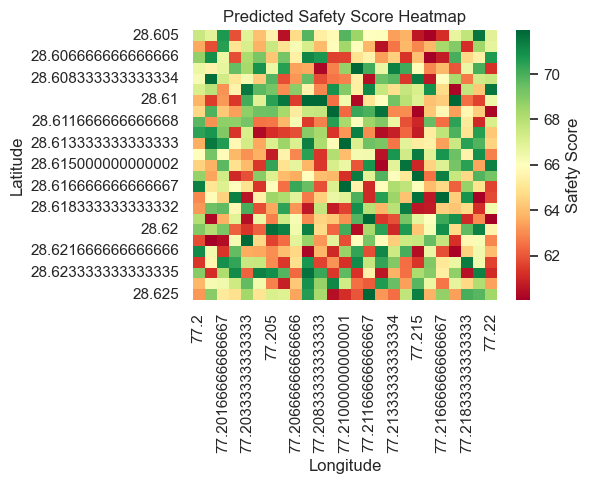

,lat,lng,safety_score
0,28.605,77.200000,67.529787
1,28.605,77.200833,66.831297
2,28.605,77.201667,70.690910
3,28.605,77.202500,61.891320
4,28.605,77.203333,66.884062


In [15]:
# Define a 10x10 grid around India Gate area
latitudes = np.linspace(28.605, 28.625, 25)
longitudes = np.linspace(77.200, 77.220, 25)

heatmap_records = []
for lat in latitudes:
    for lng in longitudes:
        score = safety_model.predict_safety_score(lat, lng)
        heatmap_records.append({"lat": lat, "lng": lng, "safety_score": score})

heatmap_df = pd.DataFrame(heatmap_records)
heatmap_pivot = heatmap_df.pivot_table(
    index='lat', columns='lng', values='safety_score'
)

plt.figure(figsize=(6,5))
sns.heatmap(heatmap_pivot, cmap='RdYlGn', cbar_kws={'label': 'Safety Score'})
plt.title('Predicted Safety Score Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

heatmap_df.head()


### Temporal Safety Patterns

Plotting average predicted safety across hours and weekdays (based on the synthetic training set) shows the model’s time-sensitive behavior.


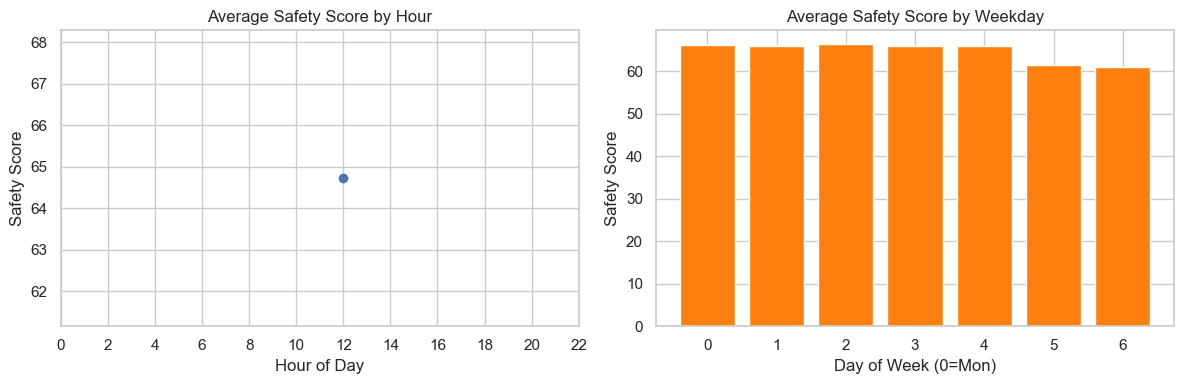

,Hour,Avg Safety Score
0,12,64.720773


In [16]:
hourly_scores = training_data.groupby('hour_of_day')['safety_score'].mean()
weekday_scores = training_data.groupby('day_of_week')['safety_score'].mean()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(hourly_scores.index, hourly_scores.values, marker='o')
axes[0].set_title('Average Safety Score by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Safety Score')
axes[0].set_xticks(range(0,24,2))

axes[1].bar(weekday_scores.index, weekday_scores.values, color='tab:orange')
axes[1].set_title('Average Safety Score by Weekday')
axes[1].set_xlabel('Day of Week (0=Mon)')
axes[1].set_ylabel('Safety Score')
plt.tight_layout()
plt.show()

pd.DataFrame({
    'Hour': hourly_scores.index,
    'Avg Safety Score': hourly_scores.values
}).head()


### Route Comparison Metrics

Comparing a few start/end points demonstrates how composite scores shift with different trip lengths.


In [17]:
route_configs = [
    {"name": "Connaught Place Loop", "start": (28.6315, 77.2167), "end": (28.6290, 77.2210)},
    {"name": "India Gate to Khan Market", "start": (28.6129, 77.2295), "end": (28.6005, 77.2273)},
    {"name": "Rajpath Stretch", "start": (28.6140, 77.2089), "end": (28.6185, 77.2330)}
]

route_summaries = []
for config in route_configs:
    opt_route = optimizer.optimize_route_with_safety_scoring(
        start_lat=config["start"][0],
        start_lng=config["start"][1],
        end_lat=config["end"][0],
        end_lng=config["end"][1]
    )
    route_summaries.append(
        {
            "Route": config["name"],
            "Total Safety Score": opt_route.total_safety_score,
            "Travel Time (min)": opt_route.total_travel_time,
            "Route Confidence": opt_route.route_confidence
        }
    )

route_compare_df = pd.DataFrame(route_summaries)
route_compare_df


,Route,Total Safety Score,Travel Time (min),Route Confidence
0,Connaught Place Loop,409.256970,30.0,0.819867
1,India Gate to Khan Market,411.557105,30.0,0.828811
2,Rajpath Stretch,402.524483,30.0,0.795206


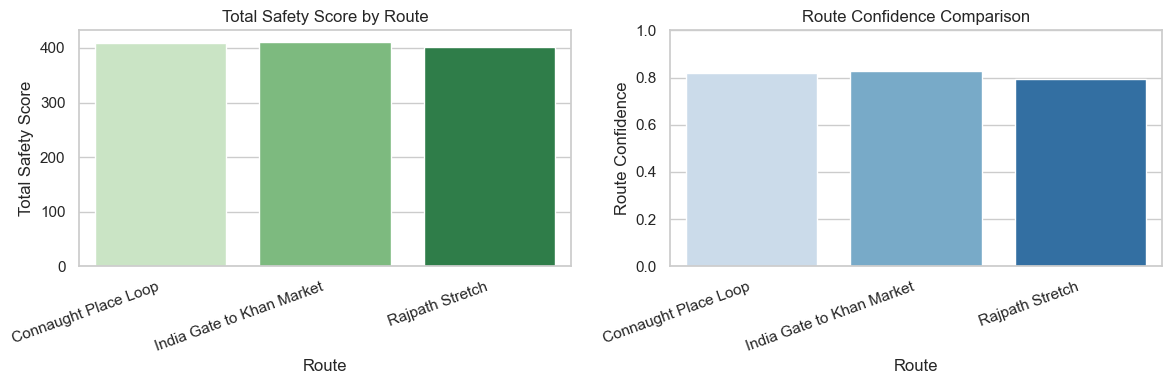

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.barplot(data=route_compare_df, x='Route', y='Total Safety Score', ax=axes[0], palette='Greens')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=20, ha='right')
axes[0].set_title('Total Safety Score by Route')

sns.barplot(data=route_compare_df, x='Route', y='Route Confidence', ax=axes[1], palette='Blues')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=20, ha='right')
axes[1].set_title('Route Confidence Comparison')
axes[1].set_ylim(0,1)

plt.tight_layout()
plt.show()


### Crime Cluster Profiles

Summaries of each K-Means cluster help describe the kinds of areas (high crime vs low population, etc.).


In [23]:
clustered_crime_df = crime_df.copy()
clustered_crime_df['cluster'] = cluster_labels

cluster_profiles = clustered_crime_df.groupby('cluster').mean(numeric_only=True)
cluster_profiles['sample_count'] = clustered_crime_df.groupby('cluster').size()
cluster_profiles = cluster_profiles[[
    'sample_count', 'crime/area', 'totarea', 'totalcrime', 'murder', 'rape', 'theft'
]].rename(columns={
    'crime/area': 'Crime per Area',
    'totarea': 'Area (sq.m)',
    'totalcrime': 'Total Crime',
    'murder': 'Murder',
    'rape': 'Rape',
    'theft': 'Theft'
})
cluster_profiles


,sample_count,Crime per Area,Area (sq.m),Total Crime,Murder,Rape,Theft
cluster,,,,,,,
0,41,80.357424,8.373982e+06,229.512195,1.463415,4.951220,197.731707
1,20,128.901633,1.026965e+07,479.300000,2.300000,9.450000,403.600000
2,36,138.999009,5.264166e+06,411.222222,4.750000,18.583333,325.305556
3,10,483.966786,2.365886e+06,1031.300000,4.900000,18.700000,873.900000
4,18,233.029515,7.658743e+06,622.222222,7.666667,19.833333,493.444444
5,41,188.776076,8.234010e+06,589.780488,2.780488,8.487805,509.536585


### Anomaly Detection Timeline

Simulating a short trip through the `DynamicGeofencing` system illustrates how alert phases progress when thresholds are crossed.


In [20]:
from datetime import timedelta
from dynamic_geofencing import DynamicGeofencing

geofence = DynamicGeofencing(safety_model=safety_model)
geofence.safety_score_threshold = 60  # make alerts easier to trigger
geofence.anomaly_threshold = 1.5  # minutes
planned_route = [
    (28.6139, 77.2090),
    (28.6145, 77.2095),
    (28.6150, 77.2100)
]
geofence.set_planned_route(planned_route)

simulation_points = [
    {"lat": 28.6139, "lng": 77.2090, "speed": 4.0, "hold_minutes": 0},
    {"lat": 28.6142, "lng": 77.2096, "speed": 0.5, "hold_minutes": 2},  # stopped in moderate area
    {"lat": 28.6148, "lng": 77.2105, "speed": 0.2, "hold_minutes": 3},  # continued stop triggers escalation
    {"lat": 28.6160, "lng": 77.2125, "speed": 0.0, "hold_minutes": 4}   # further deviation
]

phase_records = []
for idx, point in enumerate(simulation_points):
    anomaly = geofence.update_user_location(point['lat'], point['lng'], point['speed'])
    if point['hold_minutes'] > 0 and geofence.user_location_history:
        geofence.user_location_history[-1].timestamp -= timedelta(minutes=point['hold_minutes'])
    status = geofence.get_current_safety_status()
    phase_records.append({
        'step': idx + 1,
        'latitude': point['lat'],
        'longitude': point['lng'],
        'speed': point['speed'],
        'phase': status['current_phase'],
        'anomaly_detected': anomaly
    })

phase_df = pd.DataFrame(phase_records)
phase_df


SOFT CHECK ALERT: {'phase': 'soft_check', 'message': "It looks like you've paused in a low-safety area. Are you okay?", 'location': {'lat': 28.616, 'lng': 77.2125}, 'timestamp': '2025-11-14T12:45:43.129477', 'actions': ["Tap to confirm you're okay", 'Hold for 3 seconds to alert emergency contacts']}


,step,latitude,longitude,speed,phase,anomaly_detected
0,1,28.6139,77.2090,4.0,normal,False
1,2,28.6142,77.2096,0.5,normal,False
2,3,28.6148,77.2105,0.2,normal,False
3,4,28.6160,77.2125,0.0,soft_check,True


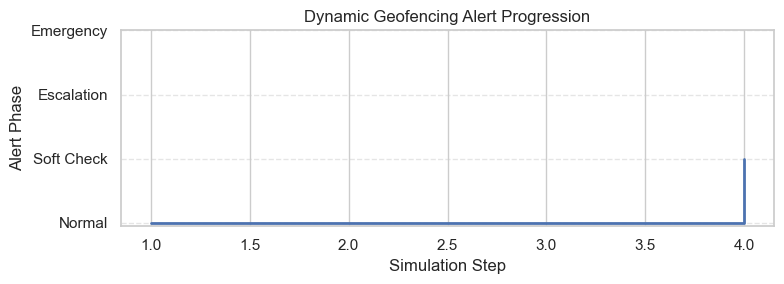

In [21]:
phase_order = ['normal', 'soft_check', 'escalation', 'emergency']
phase_df['phase_value'] = phase_df['phase'].apply(lambda p: phase_order.index(p))

plt.figure(figsize=(8,3))
plt.step(phase_df['step'], phase_df['phase_value'], where='post', linewidth=2)
plt.yticks(range(len(phase_order)), [label.title().replace('_', ' ') for label in phase_order])
plt.xlabel('Simulation Step')
plt.ylabel('Alert Phase')
plt.title('Dynamic Geofencing Alert Progression')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
